In [1]:
import time

import numpy as np
import pandas as pd

from Utils.discrete_family import discrete_family
from Utils.barrier_affine import solve_barrier_tree, solve_barrier_tree_nonneg, solve_barrier_tree_box_PGD
from CART import RegressionTree
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal as mvn
from Utils.plotting import  *
from Utils.simulation_helpers import *
from scipy.stats import norm as ndist

# For tree-values
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector

# Select a CRAN mirror to download from
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)  # Select the first mirror

# Install 'remotes' if it's not already installed
if not rpackages.isinstalled('remotes'):
    utils.install_packages(StrVector(('remotes',)))

import rpy2.robjects as ro

from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import numpy2ri
%load_ext rpy2.ipython

# Main ideas
1. Generate data from the tree-values setting:
> We simulate $X \in \mathbb{R}^{n \times p}$ with $n=200, p=10, X_{i j} \stackrel{i . i . d .}{\sim} N(0,1)$, and $y \sim N_n\left(\mu, \sigma^2 I_n\right)$ with $\sigma=5$ and $\mu_i=b \times\left[1_{\left(x_{i, 1} \leq 0\right)} \times\left\{1+a 1_{\left(x_{i, 2}>0\right)}+1_{\left(x_{i, 3} \times x_{i, 2}>0\right)}\right\}\right]$. 
2. Fix a maximum depth $max\_depth$, e.g. $5$.
3. Use naive inference, tree-values, and our proposed method to fit the tree.
4. Coverage rate comparison: compare the average coverage rate over CIs for terminal nodes in each simulation.
5. Average length comparison: compare the average CIs lengths for terminal nodes in each simulation.
6. Selection quality comparison: 
a. generate the same dataset with same $X, \mu$ but new $\epsilon$,
b. generate new $X, \mu$, \epsilon$ using the same parameters,
compare the MSE of fitted trees on this test set.

In [5]:
# Activate automatic conversion between pandas and R data frames
pandas2ri.activate()

# Import R libraries
treevalues = importr('treevalues')
rpart = importr('rpart')

def tree_values_inference(X, y, mu, max_depth=5, level=0.1,
                          X_test=None):
    # Convert the NumPy matrix to an R matrix
    X_r = numpy2ri.py2rpy(X)
    y_r = numpy2ri.py2rpy(y)
    
    # Assign the R matrix to a variable in the R environment (optional)
    ro.globalenv['X_r'] = X_r
    ro.globalenv['y_r'] = y_r
    ro.globalenv['p'] = X.shape[1]
    
    # Construct dataset
    ro.r('data <- cbind(y_r, X_r)')
    # Set the column names to "y", "x1", "x2", ..., "x10"
    ro.r('colnames(data) <- c("y", paste0("x", 1:p))')
    ro.r('data = data.frame(data)')
    
    # Define the rpart tree model
    tree_cmd = ('bls.tree <- rpart(y ~ ., data=data, model = TRUE, ' + 
                'control = rpart.control(cp=0.00, minsplit = 25, minbucket = 10, maxdepth=') + str(max_depth) + '))'
    ro.r(tree_cmd)
    bls_tree = ro.r('bls.tree')
    # Plot the tree values (this will plot directly if you have a plotting backend set up)
    #ro.r('treeval.plot(bls.tree, inferenceType=0)')
    
    #ro.r('print(row.names(bls.tree$frame)[bls.tree$frame$var == "<leaf>"])')
    ro.r('leaf_idx <- (row.names(bls.tree$frame)[bls.tree$frame$var == "<leaf>"])')
    leaf_idx = ro.r['leaf_idx']
    
    # Get node mapping
    ro.r('idx_full <- 1:nrow(bls.tree$frame)')
    ro.r('mapped_idx <- idx_full[bls.tree$frame$var == "<leaf>"]')
    
    len = []
    coverage = []
    
    for i,idx in enumerate(leaf_idx):
        # Get the branch information for a specific branch in the tree
        command = 'branch <- getBranch(bls.tree, ' + str(idx) + ')'
        ro.r(command)
        # Perform branch inference
        ro.r('result <- branchInference(bls.tree, branch, type="reg", alpha = 0.10)')
        # Get confidence intervals
        confint = ro.r('result$confint')
        len.append(confint[1] - confint[0])
    
        target_cmd = "contrast <- (bls.tree$where == mapped_idx[" + str(i+1) + "])"
        ro.r(target_cmd)
        contrast = ro.r('contrast')
        contrast = np.array(contrast)
        
        contrast = np.array(contrast * 1 / np.sum(contrast))
        
        target = contrast.dot(mu)
        coverage.append(target >= confint[0] and target <= confint[1])
    
    if X_test is not None:
        X_test_r = numpy2ri.py2rpy(X_test)
        ro.globalenv['X_test_r'] = X_test_r
        ro.r('pred <- predict(bls.tree, data = X_test_r)')
        pred = ro.r['pred']
    else:
        pred = None
        
    return (np.mean(coverage), np.mean(len), pred) 

In [6]:
def generate_test_laplace(mu, sd_y):
    n = mu.shape[0]
    return mu + np.random.laplace(0, sd_y/np.sqrt(2), n)

In [7]:
def randomized_inference(reg_tree, sd_y, y, mu, level=0.1):
    #print(reg_tree.terminal_nodes)
    coverage_i = []
    lengths_i = []
    
    for node in reg_tree.terminal_nodes:
        pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs \
            = (reg_tree.condl_node_inference(node=node, 
                                             ngrid=10000,
                                             ncoarse=50,
                                             grid_w_const=3,
                                             reduced_dim=1,
                                             sd=sd_y,
                                             use_cvxpy=True))
        target = contrast.dot(mu)
        
        # This is an interval for
        # eta_*'mu = eta'mu / (norm(eta) * sd_y)
        selective_CI = (dist.equal_tailed_interval(observed=norm_contrast.dot(y),
                                                   alpha=level))
        selective_CI = np.array(selective_CI)
        selective_CI *= np.linalg.norm(contrast) * sd_y
        coverage_i.append((target >= selective_CI[0] and target <= selective_CI[1]))
        lengths_i.append(selective_CI[1] - selective_CI[0])
        
    return coverage_i, lengths_i

In [10]:
import itertools
def vary_signal_sim(n = 50, p = 5, sd_y_list = [1, 2, 5, 10], noise_sd=1, 
                    start=0, end=100, level=0.1):
    oper_char = {}
    oper_char["Coverage Rate"] = []
    oper_char["Length"] = []
    oper_char["MSE"] = []
    oper_char["Method"] = []
    oper_char["SD(Y)"] = []
    #oper_char["a"] = []
    #oper_char["b"] = []
    a = 1
    b = 2
    
    #for ab_prod in itertools.product(a_list, b_list):
        #a = ab_prod[0]
        #b = ab_prod[1]
    for sd_y in sd_y_list:
        for i in range(start, end):
            print(i, "th simulation")
            #np.random.seed(i + 48105)
            X = np.random.normal(size=(n, p))
    
            mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
            y = mu + np.random.laplace(0, sd_y/np.sqrt(2), n)
            y_test = generate_test_laplace(mu, sd_y)
            
            # Create and train the regression tree
            reg_tree = RegressionTree(min_samples_split=50, max_depth=3,
                                      min_proportion=0., min_bucket=20)
            reg_tree.fit(X, y, sd = noise_sd * sd_y)
            
            # RRT Inference
            coverage_i, lengths_i = randomized_inference(reg_tree=reg_tree, 
                                                         y=y, sd_y=sd_y, mu=mu, 
                                                         level=level)
            pred_test = reg_tree.predict(X)
            MSE_test = (np.mean((y_test - pred_test) ** 2))
            # Record results
            oper_char["Coverage Rate"].append(np.mean(coverage_i))
            oper_char["Length"].append(np.mean(lengths_i))
            oper_char["MSE"].append(MSE_test)
            oper_char["Method"].append("RRT")
            oper_char["SD(Y)"].append(sd_y)
            #oper_char["a"].append(a)
            #oper_char["b"].append(b)
                
            # Tree value & naive inference & prediction
            (coverage_treeval, avg_len_treeval, 
             pred_test_treeval) = tree_values_inference(X, y, mu,
                                                        X_test=X, max_depth=3)
            MSE_test_treeval = (np.mean((y_test - pred_test_treeval) ** 2))
            
            oper_char["Coverage Rate"].append(coverage_treeval)
            oper_char["Length"].append(avg_len_treeval)
            oper_char["MSE"].append(MSE_test_treeval)
            oper_char["Method"].append("Tree-Values")
            oper_char["SD(Y)"].append(sd_y)
            #oper_char["a"].append(a)
            #oper_char["b"].append(b)
        
    return oper_char

In [11]:
oper_char = vary_signal_sim(n = 50, p = 5, sd_y_list=[1, 2, 5], 
                            noise_sd=1, 
                            start=0, end=50, level=0.1)

0 th simulation


/Users/yilingh/Desktop/PhD/SI_Codes/SI-CART/Utils/discrete_family.py:148: RuntimeWarning: overflow encountered in exp
  self._partition *= np.exp(_largest)


1 th simulation


/Users/yilingh/Desktop/PhD/SI_Codes/SI-CART/Utils/discrete_family.py:148: RuntimeWarning: overflow encountered in scalar multiply
  self._partition *= np.exp(_largest)


2 th simulation
3 th simulation
4 th simulation
5 th simulation
6 th simulation
7 th simulation
8 th simulation
9 th simulation
10 th simulation
11 th simulation
12 th simulation
13 th simulation
14 th simulation
15 th simulation
16 th simulation
17 th simulation
18 th simulation
19 th simulation
20 th simulation
21 th simulation
22 th simulation
23 th simulation
24 th simulation
25 th simulation
26 th simulation
27 th simulation
28 th simulation
29 th simulation
30 th simulation
31 th simulation
32 th simulation
33 th simulation
34 th simulation
35 th simulation
36 th simulation
37 th simulation
38 th simulation
39 th simulation
40 th simulation
41 th simulation
42 th simulation
43 th simulation
44 th simulation
45 th simulation
46 th simulation
47 th simulation
48 th simulation
49 th simulation
0 th simulation
1 th simulation
2 th simulation
3 th simulation
4 th simulation
5 th simulation
6 th simulation
7 th simulation
8 th simulation
9 th simulation
10 th simulation
11 th simulatio

In [12]:
oper_char_df = pd.DataFrame(oper_char)

In [13]:
oper_char_df.groupby(['Method', 'SD(Y)']).mean()

Coverage Rate     Length        MSE
Method      SD(Y)                                     
RRT         1           0.920000   2.876164   2.178542
            2           0.930000   2.858427   5.268825
            5           0.950000  11.769234  28.443954
Tree-Values 1           0.936667   5.890562   1.780230
            2           0.916667  11.093734   5.262744
            5           0.913333  59.402852  31.174139

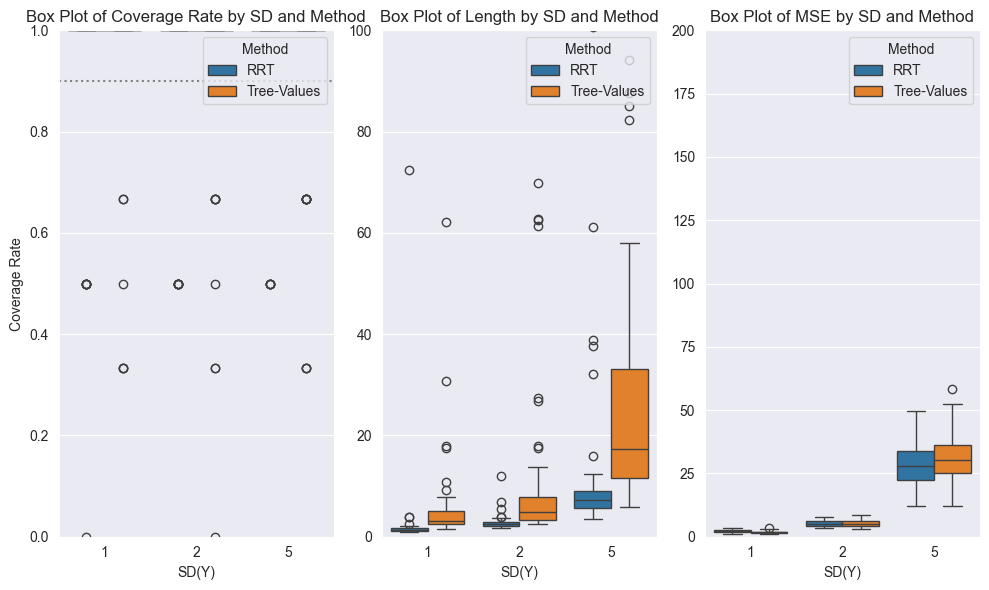

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
metrics = ["Coverage Rate", "Length", "MSE"]

# Set up the figure and axes for subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 6), sharey=False)

# Iterate over each metric and create a box plot
for i, metric in enumerate(metrics):
    sns.boxplot(x='SD(Y)', y=metric, hue='Method', data=oper_char_df, ax=axes[i])
    axes[i].set_title(f'Box Plot of {metric} by SD and Method')
    axes[i].set_xlabel('SD(Y)')
    axes[i].set_ylabel(metric if i == 0 else '')  # Only set ylabel on the first plot for clarity
    axes[i].legend(title='Method', loc='upper right')
    if metric == "Coverage Rate":
        axes[i].set_ylim(0,1)
        axes[i].axhline(y=0.9, linestyle='dotted', color='grey')
    elif metric == "Length":
        axes[i].set_ylim(0,100)
    elif metric == "MSE":
        axes[i].set_ylim(0,200)

# Adjust layout and display
plt.tight_layout()
plt.show()

